# Exploration de l'auto-encodeur de Dall-E

Il serait intéressant de savoir ce qu'on peut utiliser ou non de l'auto-encodeur de Dall-E et bien s'assurer que le code recoupe ce qui est décrit dans l'article. Pour ce faire, on repart du [notebook mis à disposition par OpenAI](https://github.com/openai/DALL-E/blob/master/notebooks/usage.ipynb) sur [le dépot Github](https://github.com/openai/DALL-E) consacré à Dall-E.

## 1. Le notebook mis à disposition par Dall-E

Celui-ci permet de reconstuire une image après l'avoir compressée.

In [ ]:
import torch
from dall_e import load_model

# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

In [ ]:
import PIL
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from dall_e          import map_pixels

target_image_size = 256

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [ ]:
import PIL
import requests
import io

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

/shared-libs/python3.7/py/lib/python3.7/site-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


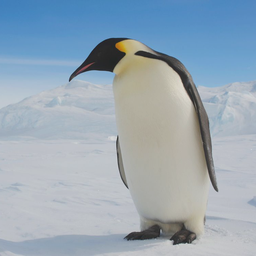

In [ ]:
from IPython.display import display, display_markdown

x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

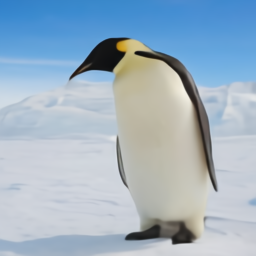

In [ ]:
import torch.nn.functional as F
from dall_e          import unmap_pixels


z_logits = enc(x)
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

## 2. Exploration des composantes

Idéalement nous souhaterions construire une matrice $(25\times 25, 3968)$ de chaque token-image / méta-pixel décrit dans le plongement.

L'objet `z_logit` contient des scores pour chaque meta-pixel d'être de la catégorie $d$, où $d$ peut prendre les valeurs de $1$ à $D=8192$.

In [ ]:
z_logits.size()

torch.Size([1, 8192, 32, 32])

In [ ]:
z_logits[0][0]

tensor([[102.0591, 123.7356, 118.0825,  ..., 122.4455, 109.0738,  90.1132],
        [125.4890, 135.9749, 158.7835,  ..., 112.8804, 127.0198,  91.6430],
        [149.6203, 194.5109, 188.2533,  ..., 113.8263, 158.7303, 115.9380],
        ...,
        [151.7779, 204.4524, 129.6727,  ...,  71.8784,  64.1299,  84.4097],
        [ 85.6733,  84.7962,  78.9239,  ..., 157.9830, 128.4029, 148.9574],
        [141.4379, 183.8740, 105.4718,  ..., 143.9356, 157.2750, 119.4951]],
       grad_fn=<SelectBackward0>)

In [ ]:
# la plus grande valeur donne la catégorie d la plus probable
# qui est encodée dans z par 1 pour la colonne d, 0 pour toutes les autres

# z = torch.argmax(z_logits, axis=1)
y = z.sum(axis=1) # on vérifie que la somme des valeurs pour chaque meta-pixel fait 1
y.size() # taille 32 x 32

torch.Size([1, 32, 32])

In [ ]:
y

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

On ne voit pas le dictionnaire / codebook qui permet de convertir chaque méta-pixel (encodé de façon discrète par 1 catégorie d sélectionnées parmi D possibles) en un vecteur numérique (la ligne $d$ du dictionnaire / codebook contenant le vecteur). On ne trouve pas ce codebook en clair dans le code. Peut-être est-il un attribut de l'encoodeur, comme la taille du vocabulaire?

In [ ]:
enc.vocab_size

8192

In [ ]:
dir(enc)

['T_destination',
 '__annotations__',
 '__attrs_attrs__',
 '__attrs_post_init__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_

In [ ]:
enc.parameters

<bound method Module.parameters of Encoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=3, n_out=256, kw=7, use_float16=True, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): EncoderBlock(
        (id_path): Identity()
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=256, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=64, n_out=256, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): EncoderBlock(
        (id_path): Identity()
        (res_path): Sequential(
        

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f3692ed-5f27-49a4-899a-82a03e72232c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>